### Topic Modeling on the extracted slack data 

#### Import required libraries

In [1]:
import pandas as pd
import nltk
import spacy

## Uncomment and run the first time
#!python -m spacy download en

In [2]:
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Read Data from the csv files

In [4]:
## read data
df_msgs_replies = pd.read_csv('data/ecv_analytics_scanning_data.csv')

In [5]:
len(df_msgs_replies)

988

In [6]:
len(df_msgs_replies.user.unique())

86

### Data Cleaning and Pre-processing

In [7]:
# Convert to list
data = df_msgs_replies.text.values.tolist()

In [8]:
## Tokenization

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # lowercase the words and deacc=True removes punctuations

data_words = list(sent_to_words(data))


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    ### can add more stopwords here
    stop_words.extend(['https','com','org','www','covid','coronavirus','help'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    ## Part-of-Speech Tagging of words and keep only the Nouns, Adjectives, Verbs and Adverbs
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN','PROPN','ADJ'])

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('development', 1),
  ('good', 1),
  ('govchrissununu', 2),
  ('nh', 1),
  ('status', 2),
  ('twitter', 2)]]

### Select the number of topics for the topic model based on the coherence scores

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        ## Build an LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, random_state = 42)
       
        model_list.append(model)
        ## compute the coherence scores
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
# Going from 2 to 40 topics with step size of 5
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=5)

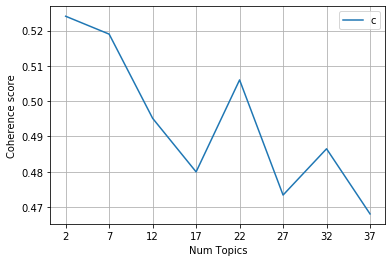

In [15]:
# Show graph
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(ticks = x, labels=x)
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

### Building an LDA Model with 22 topics

In [18]:
# Select the model and print the topics and most important keywords
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics())

[(0,
  '0.022*"release" + 0.021*"team" + 0.014*"testing" + 0.011*"uuy" + '
  '0.011*"initiative" + 0.011*"italian" + 0.009*"health" + 0.008*"news" + '
  '0.008*"well" + 0.008*"public"'),
 (1,
  '0.041*"datum" + 0.019*"data" + 0.018*"province" + 0.014*"private" + '
  '0.013*"italy" + 0.013*"uungc" + 0.013*"uq" + 0.013*"hef" + '
  '0.013*"publication" + 0.012*"need"'),
 (2,
  '0.018*"community" + 0.016*"mj" + 0.016*"website_dev" + 0.015*"ms" + '
  '0.014*"public" + 0.014*"people" + 0.012*"outreach" + 0.011*"cuuabp" + '
  '0.011*"correct" + 0.011*"liability"'),
 (3,
  '0.022*"test" + 0.016*"time" + 0.016*"website" + 0.015*"team" + 0.013*"kit" '
  '+ 0.012*"ed" + 0.011*"series" + 0.010*"seattle" + 0.010*"health" + '
  '0.010*"capacity"'),
 (4,
  '0.018*"italian" + 0.010*"direct" + 0.010*"wikipedia" + 0.009*"official" + '
  '0.009*"channel" + 0.009*"wiki" + 0.009*"chemistry" + 0.009*"kdl" + '
  '0.009*"incentive" + 0.009*"procedure"'),
 (5,
  '0.024*"pdf" + 0.023*"thank" + 0.014*"list" + 0.

In [19]:
# # Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/Users/akshatapatel/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.027269 -0.015069       1        1  13.307807
11     0.012604  0.035980       2        1  12.177207
0      0.002011  0.032752       3        1  10.948180
5     -0.020452 -0.060917       4        1   9.603847
2      0.189082 -0.023728       5        1   8.768579
4     -0.013549 -0.011128       6        1   7.832530
3      0.047104  0.093794       7        1   7.128356
1     -0.061705  0.016598       8        1   6.886158
10     0.008933 -0.017253       9        1   6.825972
8     -0.048777 -0.143700      10        1   6.633983
6     -0.081266  0.100162      11        1   6.097550
7     -0.006716 -0.007491      12        1   3.789839, topic_info=     Category        Freq     Term       Total  loglift  logprob
2636  Default   84.000000     clia   84.000000  30.0000  30.0000
2976  Default   97.000000      gov   97.000000  29.0000  29.0000
305   Default  132.000000     http  132.000000  28.0000  28.0000
97    Default  181.000000     test  181.000000  27.0000  27.0000
405   Default   68.000000   region   68.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
4050  Topic12    2.010417       ms   35.517559   0.4012  -6.1373
147   Topic12    2.362162     time   69.732498  -0.1122  -5.9760
96    Topic12    2.896503     team  192.364426  -0.9230  -5.7721
282   Topic12    1.917918  general   42.712830   0.1696  -6.1844
395   Topic12    1.870876  message   49.755707  -0.0079  -6.2092

[601 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1151      1  0.066852          _
1151      3  0.378830          _
1151      4  0.022284          _
1151      5  0.022284          _
1151      6  0.022284          _
...     ...       ...        ...
2045      1  0.063856  yesterday
2045      5  0.063856  yesterday
2045      6  0.063856  yesterday
2045      8  0.702418  yesterday
503       1  0.660729    yorkers

[1897 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 12, 1, 6, 3, 5, 4, 2, 11, 9, 7, 8])

In [20]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data, users = df_msgs_replies['user']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents,users], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data, users= df_msgs_replies['user'])


In [21]:
# Group top sentence under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Users"]

# Show
sent_topics_sorteddf

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.9805   
1         0.0              0.9758   
2         0.0              0.9738   
3         0.0              0.9684   
4         0.0              0.9683   
5         1.0              0.9752   
6         1.0              0.9752   
7         1.0              0.9713   
8         1.0              0.9694   
9         1.0              0.9684   
10        2.0              0.9800   
11        2.0              0.9771   
12        2.0              0.9633   
13        2.0              0.9583   
14        2.0              0.9583   
15        3.0              0.9730   
16        3.0              0.9684   
17        3.0              0.9633   
18        3.0              0.9601   
19        3.0              0.9583   
20        4.0              0.9817   
21        4.0              0.9813   
22        4.0              0.9704   
23        4.0              0.9647   
24        4.0              0.9647   
25        5.0              0.9893   
26        5.0              0.9722   
27        5.0              0.9722   
28        5.0              0.9683   
29        5.0              0.9660   
30        6.0              0.9738   
31        6.0              0.9600   
32        6.0              0.9541   
33        6.0              0.9517   
34        6.0              0.9517   
35        7.0              0.9684   
36        7.0              0.9672   
37        7.0              0.9647   
38        7.0              0.9517   
39        7.0              0.9345   
40        8.0              0.9633   
41        8.0              0.9460   
42        8.0              0.9460   
43        8.0              0.9426   
44        8.0              0.9294   
45        9.0              0.9956   
46        9.0              0.9933   
47        9.0              0.9904   
48        9.0              0.9856   
49        9.0              0.9758   
50       10.0              0.9863   
51       10.0              0.9791   
52       10.0              0.9704   
53       10.0              0.9684   
54       10.0              0.9633   
55       11.0              0.9925   
56       11.0              0.9781   
57       11.0              0.9738   
58       11.0              0.9609   
59       11.0              0.9601   

                                             Keywords  \
0   release, team, testing, uuy, initiative, itali...   
1   release, team, testing, uuy, initiative, itali...   
2   release, team, testing, uuy, initiative, itali...   
3   release, team, testing, uuy, initiative, itali...   
4   release, team, testing, uuy, initiative, itali...   
5   datum, data, province, private, italy, uungc, ...   
6   datum, data, province, private, italy, uungc, ...   
7   datum, data, province, private, italy, uungc, ...   
8   datum, data, province, private, italy, uungc, ...   
9   datum, data, province, private, italy, uungc, ...   
10  community, mj, website_dev, ms, public, people...   
11  community, mj, website_dev, ms, public, people...   
12  community, mj, website_dev, ms, public, people...   
13  community, mj, website_dev, ms, public, people...   
14  community, mj, website_dev, ms, public, people...   
15  test, time, website, team, kit, ed, series, se...   
16  test, time, website, team, kit, ed, series, se...   
17  test, time, website, team, kit, ed, series, se...   
18  test, time, website, team, kit, ed, series, se...   
19  test, time, website, team, kit, ed, series, se...   
20  italian, direct, wikipedia, official, channel,...   
21  italian, direct, wikipedia, official, channel,...   
22  italian, direct, wikipedia, official, channel,...   
23  italian, direct, wikipedia, official, channel,...   
24  italian, direct, wikipedia, official, channel,...   
25  pdf, thank, list, kind, fact, twitter, info, n...   
26  pdf, thank, list, kind, fact, twitter, info, n...   
27  pdf, thank, list, kind, fact, twitter, info, n...   
28  pdf, thank, list, kind, fact, twitter, info, n...   
29  pdf, thank, list, kind, fact, tw

In [22]:
# sent_topics_sorteddf.to_csv('ecv_general_help_wanted_topics_text_5_users.csv')

In [23]:
for i in sent_topics_sorteddf['Topic_Num'].unique():
    print('Topic: ',i)
    df_topic = sent_topics_sorteddf[sent_topics_sorteddf['Topic_Num']==i]['Text']
    for j in (df_topic.values):
        print(j)
        print('--------------------------------------------------------------')
    print('#####################################')

Topic:  0.0
Hello everyone, we are working on a digital platform for doctors that informs them about different treatment regimens being tried across the globe and which of these are effective, to save lives. This project was a winner at the MIT COVID19 Hackathon- Healthcare track.
 
A quick video pitch is here: <https://www.youtube.com/watch?v=XECtIvzGPbM>
 
We are currently looking to create a venture and apply for funding and are looking for the following:
 
1..Full stack developer - preferably as a core team member.                                                                   2. Partnerships with Clinicians/ Hospitals, government organizations and philanthropic agencies for data collection. (If you are a clinician please get in touch with us also to advise and help us test our MVP). -Would love to talk more, please write to us at: <mailto:covengers101@gmail.com|covengers101@gmail.com>.
--------------------------------------------------------------
*I AM EXTREMELY FRUSTRATED, AN

#### References
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda